# RTP Forecasting

In [1]:
pip install keras-tuner --upgrade

Note: you may need to restart the kernel to use updated packages.


In [2]:
import argparse
import os
import random
import numpy as np
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

import sys 
import scipy.io
import math
from datetime import date       

import imageio

import tensorflow as tf
from tensorflow import keras
import keras
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Lambda, LSTM
from tensorflow.keras.layers import concatenate, Input, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import keras_tuner


%load_ext autoreload
%autoreload 2
%matplotlib inline

2023-11-19 14:34:29.723308: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-19 14:34:29.762271: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(tf.__version__)

2.12.1


In [4]:
cwd = os.getcwd()

In [5]:
def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)

In [6]:
#timing callback
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [7]:
# Plot history and future
def plot_predictions(pred , actual, title):
    plt.figure(figsize=(20, 4), dpi=150)
    plt.plot(np.arange(len(pred)), np.array(pred),label='LSTM',alpha=0.7)
    plt.plot(np.arange(len(pred)), np.array(actual),label='PF', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', lw=1, alpha=0.5)
    plt.legend(loc='upper right')
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('Price' , fontsize=18)
    plt.title(title, fontsize=16)

In [8]:
#zones = ['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', 'LONGIL',
#         'MHK VL', 'MILLWD', 'N.Y.C.', 'NORTH', 'WEST']
zone = 'N.Y.C.'
year = 2021

### Data Import

In [9]:
# Read each timeseries (RTP = Real-Time Price, DAP = Day-Ahead Price, LF = Load Forecast)
raw_DAP = pd.read_csv("nyiso/da_lmp_zones_df_2015_2021.csv", index_col=0)
raw_RTP = pd.read_csv("nyiso/rt_lmp_zones_df_2015_2021.csv", index_col=0)
raw_LF = pd.read_csv("nyiso/load_frcstd_df_2015_2021.csv", index_col=0)

In [10]:
# Prepare the dataset as a dataframe
raw_data = pd.concat([raw_DAP.loc[:,zone], raw_LF.loc[:,zone], raw_RTP.loc[:,zone]],
                       axis=1).loc['2017-01-01 05:00:00+00:00':]
raw_data.columns = ['DAP', 'LF', 'RTP']
raw_data.index.names = ['date']
raw_data.to_csv('nyiso/NYISO_'+zone+'_raw.csv')

In [11]:
raw_data

,DAP,LF,RTP
date,,,
2017-01-01 05:00:00+00:00,33.60,5065,32.28
2017-01-01 06:00:00+00:00,32.05,4934,30.77
2017-01-01 07:00:00+00:00,29.23,4812,31.17
2017-01-01 08:00:00+00:00,25.02,4728,32.00
2017-01-01 09:00:00+00:00,26.94,4665,27.89
...,...,...,...
2022-01-01 00:00:00+00:00,33.49,5362,30.21
2022-01-01 01:00:00+00:00,31.28,5139,30.23
2022-01-01 02:00:00+00:00,30.49,4943,30.34


In [12]:
# We perform log tranformation before feeding the dataset into the model to make enhance the performance
# We only log tranform the price data (RTP and DAP)
log = 1
# log transformation for the forecasting task log10(Y + 1 - min(Y))
if log:
    log_data = raw_data.copy(deep=True)
    log_data.loc[:,"DAP"] = np.log(raw_data.loc[:,"DAP"] + 1 - min(raw_data.loc[:,"DAP"]))
    log_data.loc[:,"RTP"] = np.log(raw_data.loc[:,"RTP"] + 1 - min(raw_data.loc[:,"RTP"]))
    log_data.to_csv('nyiso/NYISO_'+zone+'_log.csv')

In [13]:
log_data

,DAP,LF,RTP
date,,,
2017-01-01 05:00:00+00:00,3.361417,5065,5.143475
2017-01-01 06:00:00+00:00,3.306154,4934,5.134621
2017-01-01 07:00:00+00:00,3.197039,4812,5.136974
2017-01-01 08:00:00+00:00,3.008155,4728,5.141839
2017-01-01 09:00:00+00:00,3.098740,4665,5.117515
...,...,...,...
2022-01-01 00:00:00+00:00,3.357594,5362,5.131318
2022-01-01 01:00:00+00:00,3.277522,5139,5.131436
2022-01-01 02:00:00+00:00,3.247269,4943,5.132086


### Data Preprocessing

In [14]:
# Split dataset: 2015 year for training and 2016-2017 years for testing
x_train_df = log_data.iloc[:8760*4+24,:]
x_test_df = log_data.iloc[8760*4+24:,:]

y_train_df = log_data.iloc[:8760*4+24,2:]
y_test_df = log_data.iloc[8760*4+24:,2:]

In [15]:
# # Standardization
x_mean, x_std = x_train_df.mean(), x_train_df.std()
y_mean, y_std = y_train_df.mean(), y_train_df.std()

x_train = ((x_train_df - x_mean)/x_std).to_numpy()
x_test = ((x_test_df - x_mean)/x_std).to_numpy()

y_train = ((y_train_df - y_mean)/y_std).to_numpy()
y_test = ((y_test_df - y_mean)/y_std).to_numpy()

print(x_train.shape,y_train.shape,x_test.shape, y_test.shape)

(35064, 3) (35064, 1) (8760, 3) (8760, 1)


### Reshape to (samples, steps, features)

In [16]:
n_steps_in = 72
n_steps_out = 24

x_train_lstm = np.array([x_train[i:i+n_steps_in] for i in range(0, x_train.shape[0]-n_steps_in-n_steps_out+1)])
y_train_lstm = np.array([y_train[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_train.shape[0]-n_steps_in-n_steps_out+1)])

x_test_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_lstm = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

print(x_train_lstm.shape,y_train_lstm.shape,x_test_lstm.shape,y_test_lstm.shape)

(34969, 72, 3) (34969, 24, 1) (8665, 72, 3) (8665, 24, 1)


In [17]:
minibatch_size = 64
num_epochs     = 50
n_trials       = 10



# # set hyperparameters
# n_neuron       = 64
# activation     = 'relu'
# num_epochs     = 50
# learning_rate  = 0.001
# minibatch_size = 64
# model_num      = 1

In [18]:
def build_model(hp):

    hp_neurons = hp.Choice('neurons', values=[16,32,64])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_loss = hp.Choice('loss', values=['mse','mae'])
    
    
#     n_steps_in = 24
#     n_steps_out = 24

#     x_train_lstm = np.array([x_train[i:i+n_steps_in] for i in range(0, x_train.shape[0]-n_steps_in-n_steps_out+1)])
#     y_train_lstm = np.array([y_train[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_train.shape[0]-n_steps_in-n_steps_out+1)])

#     x_test_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
#     y_test_lstm = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

#     print(x_train_lstm.shape,y_train_lstm.shape,x_test_lstm.shape,y_test_lstm.shape)
    
     # build LSTM models according to the hyperparameters
    lstm_model = keras.models.Sequential()

# lstm_model = Sequential()
    lstm_model.add(LSTM(hp_neurons,input_shape=(x_train_lstm.shape[1],x_train_lstm.shape[2]),
               return_sequences=True,activation=hp_activation))
    lstm_model.add(LSTM(hp_neurons,return_sequences=False,
               activation=hp_activation))
    lstm_model.add(Dense(hp_neurons,activation=hp_activation))
    lstm_model.add(Dense(y_train_lstm.shape[-2],activation='linear')) 

    lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))
    
    return lstm_model
# , x_train_lstm, y_train_lstm, x_test_lstm, y_test_lstm
# lstm_model.summary()

In [19]:
# Instantiate the Tuner and save the trials in a directory with customized project name
random_tuner = keras_tuner.RandomSearch(build_model, 
                                        max_trials=n_trials,
                                        seed=5,
                                        objective='val_loss', 
                                        max_retries_per_trial=0,
                                        max_consecutive_failed_trials=3,
                                        directory='random_search', 
                                        project_name='lstm_search7')

In [20]:
random_tuner.search_space_summary()

Search space summary
Default search space size: 4
neurons (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}
loss (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae'], 'ordered': False}


In [21]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

random_tuner.search(x_train_lstm, y_train_lstm, 
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    validation_split=0.2, verbose=1,
                    callbacks=[early_stop],
                    shuffle=False)

# history = lstm_model.fit(x_train_lstm, y_train_lstm, 
#                         batch_size = minibatch_size,
#                         epochs = num_epochs,
#                         validation_split=0.2, verbose=1,
#                         callbacks=[early_stop],
#                         shuffle=False)


Trial 10 Complete [00h 36m 25s]
val_loss: 0.2370855212211609

Best val_loss So Far: 0.19176627695560455
Total elapsed time: 05h 59m 54s


In [22]:
# display the model structure with the best tuning
best_model = random_tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 72, 32)            4608      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      


2023-11-19 21:10:18.616448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-19 21:10:18.617743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-19 21:10:18.618635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

                                                                 
 dense_1 (Dense)             (None, 24)                792       
                                                                 
Total params: 14,776
Trainable params: 14,776
Non-trainable params: 0
_________________________________________________________________


In [23]:
# check hyperparameters of the all tuning trials
all_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)

# print the hyperparameters of the top 3 tuning trials
for it in range(n_trials):
    print("Ranking #", str(it+1).zfill(1), "of best tuning, total trials = ", str(n_trials))
    print(all_hps[it].values)
    print("=============================================================================================")


# get the hyperparameters of the best tuning trial
best_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[0]

# # get the hyperparameters of the second ranking tuning trial
# top2_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[1]

Ranking # 1 of best tuning, total trials =  10
{'neurons': 32, 'activation': 'tanh', 'learning_rate': 0.001, 'loss': 'mse'}
Ranking # 2 of best tuning, total trials =  10
{'neurons': 32, 'activation': 'tanh', 'learning_rate': 0.0001, 'loss': 'mse'}
Ranking # 3 of best tuning, total trials =  10
{'neurons': 32, 'activation': 'sigmoid', 'learning_rate': 0.001, 'loss': 'mse'}
Ranking # 4 of best tuning, total trials =  10
{'neurons': 32, 'activation': 'tanh', 'learning_rate': 0.01, 'loss': 'mse'}
Ranking # 5 of best tuning, total trials =  10
{'neurons': 16, 'activation': 'sigmoid', 'learning_rate': 0.001, 'loss': 'mae'}
Ranking # 6 of best tuning, total trials =  10
{'neurons': 32, 'activation': 'sigmoid', 'learning_rate': 0.0001, 'loss': 'mse'}
Ranking # 7 of best tuning, total trials =  10
{'neurons': 64, 'activation': 'tanh', 'learning_rate': 0.01, 'loss': 'mse'}
Ranking # 8 of best tuning, total trials =  10
{'neurons': 32, 'activation': 'relu', 'learning_rate': 0.0001, 'loss': 'mae'

In [24]:
# Initiate an empty dataframe to store your results
tune_res = pd.DataFrame()

# Run a for loop to extract all the information we want
for trial in random_tuner.oracle.trials:
    # Get the state for this trial
    trial_state = random_tuner.oracle.trials[trial].get_state()
    
    # Create a Series contaning the hyperparameter values for this trial
    trial_hyperparameters = pd.Series(
        trial_state["hyperparameters"]["values"],
        index = trial_state["hyperparameters"]["values"].keys())
    
    # Create a Series contaning the validation loss for this trial
    trial_loss = pd.Series(trial_state["score"], index = ["val_loss"])
    
    # Combine both Series into one Series
    trial_tune_res = pd.concat([trial_hyperparameters, trial_loss])
    
    # Name the Series (such that we can trace the trial numbers in the final DataFrame)
    trial_tune_res.name = trial
    
    # Add this trial information to the DataFrame
    tune_res = pd.concat([tune_res, trial_tune_res], axis = 1)
    


# Transpose the DataFrame such that each row represents a trial (optional)
tune_res = tune_res.T

# tune_res

In [25]:
for s in range(n_trials):
    min_idx = s
    for i in range(s + 1, n_trials):
             
            # For sorting in descending order
            # for minimum element in each loop
        if (tune_res["val_loss"][i] < tune_res["val_loss"][min_idx]):
                min_idx = i
 
        # Arranging min at the correct position
    b, c = tune_res.iloc[s].copy(), tune_res.iloc[min_idx].copy()
    temp = tune_res.iloc[s].copy()
    tune_res.iloc[s] = c
    tune_res.iloc[min_idx] = temp


tune_res

,neurons,activation,learning_rate,loss,val_loss
00,32,tanh,0.001,mse,0.191766
01,32,tanh,0.0001,mse,0.193819
02,32,sigmoid,0.001,mse,0.19983
03,32,tanh,0.01,mse,0.200516
04,16,sigmoid,0.001,mae,0.237086
05,32,sigmoid,0.0001,mse,0.256971
06,64,tanh,0.01,mse,0.328912
07,32,relu,0.0001,mae,0.485965
08,16,relu,0.00001,mse,0.505513
09,16,sigmoid,0.00001,mae,0.570843


In [26]:
# data = []
# all_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)

# for it in range(n_trials):
#     a = all_hps[it].values
#     # b = random_tuner.get_best_models()[it]
#     data.append(a)
#     # data.append(b)
    


# # a = best_hps.values

# # print(a)
# # print(best_hps.get("filters"))


# df = pd.DataFrame(data, columns = ['neurons', 'activation', 'learning_rate', 'loss'] )

# df

In [27]:
## Build the model with the optimal hyperparameters
# ---------- best tuning ----------
lstm_model = random_tuner.hypermodel.build(best_hps)

# # ---------- ranking #2 tuning ----------
# model_top2 = random_tuner.hypermodel.build(top2_hps)



## re-train the model
# ---------- best tuning ----------
history_best = lstm_model.fit(x_train_lstm, y_train_lstm, 
                               batch_size = minibatch_size, 
                               epochs = num_epochs,
                               validation_split=0.2, 
                               verbose         = 1,
                               callbacks       =[early_stop],
                               shuffle         =False)
    
#                             X_train, y_train,
#                               batch_size      = minibatch_size,
#                               epochs          = num_epochs,
#                               validation_split= 0.2, 
#                               verbose         = 1,
#                               callbacks       = [early_stop])
# ---------- ranking #2 tuning ----------
# history_top2 = model_top2.fit(x_train_lstm, y_train_lstm, 
#                                batch_size      = minibatch_size,
#                                epochs          = num_epochs,
#                                validation_split=0.2, 
#                                verbose         = 1,
#                                callbacks       =[early_stop],
#                                shuffle         =False)
    
#                             # X_train, y_train,
#                             #   batch_size      = minibatch_size,
#                             #   epochs          = num_epochs,
#                             #   validation_split= 0.2, 
#                             #   verbose         = 1,
#                             #   callbacks       = [early_stop])


2023-11-19 21:10:28.209231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-19 21:10:28.210531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-19 21:10:28.211445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-11-19 21:10:28.573342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-19 21:10:28.574747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-19 21:10:28.575809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

438/438 [==============================] - ETA: 0s - loss: 0.8887

2023-11-19 21:11:15.424539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-19 21:11:15.426142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-19 21:11:15.427262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

438/438 [==============================] - 51s 111ms/step - loss: 0.8887 - val_loss: 0.2212
Epoch 2/50
438/438 [==============================] - 47s 108ms/step - loss: 0.7451 - val_loss: 0.2057
Epoch 3/50
438/438 [==============================] - 47s 108ms/step - loss: 0.6911 - val_loss: 0.2055
Epoch 4/50
438/438 [==============================] - 48s 110ms/step - loss: 0.6946 - val_loss: 0.1950
Epoch 5/50
438/438 [==============================] - 48s 110ms/step - loss: 0.6619 - val_loss: 0.1975
Epoch 6/50
438/438 [==============================] - 48s 109ms/step - loss: 0.6448 - val_loss: 0.1952
Epoch 7/50
438/438 [==============================] - 47s 107ms/step - loss: 0.6571 - val_loss: 0.1985
Epoch 8/50
438/438 [==============================] - 47s 108ms/step - loss: 0.6514 - val_loss: 0.1945
Epoch 9/50
438/438 [==============================] - 48s 109ms/step - loss: 0.6314 - val_loss: 0.1961
Epoch 10/50
438/438 [==============================] - 47s 108ms/step - loss: 0.6381

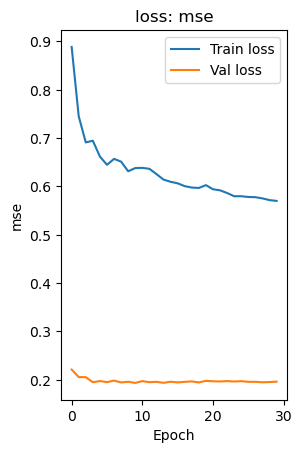

In [28]:
## set up title and ylabel strings
# ---------- best tuning ----------
title_best = 'loss: '+str(best_hps['loss'])
ylabel_best = best_hps['loss']
# # ---------- ranking #2 tuning ----------
# title_top2 = 'loss: '+str(top2_hps['loss'])
# ylabel_top2 = top2_hps['loss']


## plot history
# ---------- best tuning ----------
plt.subplot(1, 2, 1)
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title(title_best, fontsize=12)
plt.ylabel(ylabel_best)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

# # ---------- ranking #2 tuning ----------
# plt.subplot(1, 2, 2)
# plt.plot(history_top2.history['loss'])
# plt.plot(history_top2.history['val_loss'])
# plt.title(title_top2, fontsize=12)
# plt.ylabel(ylabel_top2)
# plt.xlabel('Epoch')
# plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')


In [29]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [30]:
lstm_model.save(os.path.join(model_path,'LSTM_model2.h5'))

### Evaluate

In [31]:
# reload the saved model
lstm_model = load_model(os.path.join(model_path,'LSTM_model2.h5'))

y_test_pred = lstm_model.predict(x_test_lstm)


2023-11-19 21:39:45.775673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-19 21:39:45.777081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-19 21:39:45.777959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

271/271 [==============================] - 8s 27ms/step


In [32]:
y_test_lstm.shape

(8665, 24, 1)

In [33]:
y_test_pred.shape

(8665, 24)

In [34]:
# Evaluation metrics
errors = y_test_pred - y_test_lstm[:,:,0]
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

MAE: 0.4264
RMSE: 0.6905


In [35]:
# Evaluation metrics
# 24 hours ahead
errors = y_test_pred[::24,:] - y_test_lstm[::24,:,0]
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

MAE: 0.4184
RMSE: 0.6887


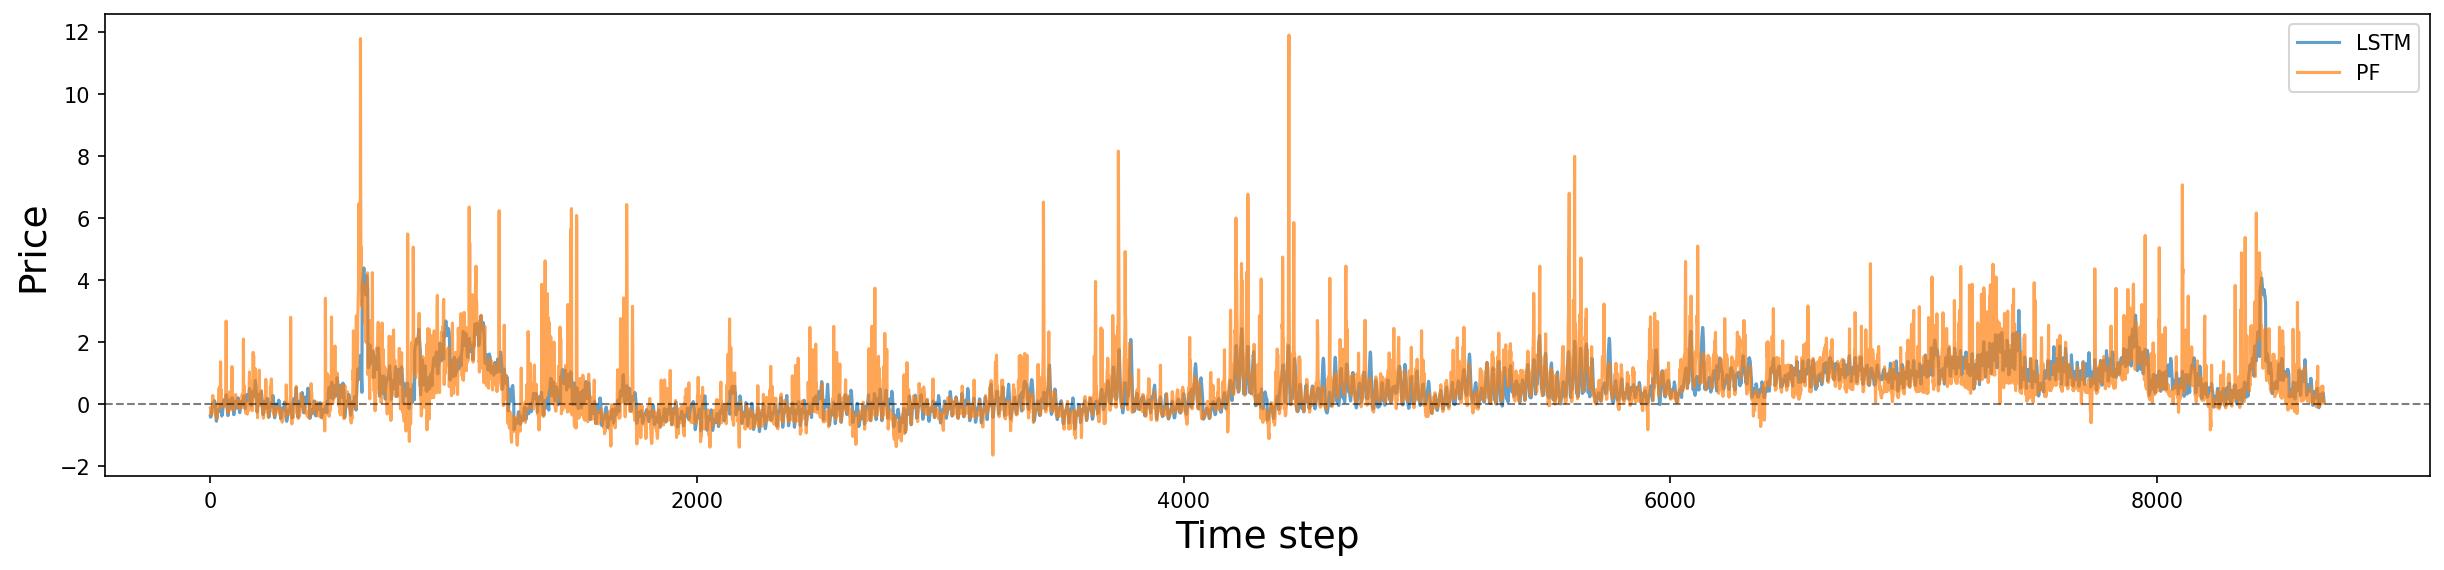

In [36]:
plot_predictions(y_test_pred[::24,:].flatten(), y_test_lstm[::24,:,0].flatten(), '')

### Rescale and evaluate performance

In [37]:
y_test_pred_rescale = y_test_pred*y_std.values + y_mean.values
y_test_lstm_rescale = y_test_lstm*y_std.values + y_mean.values

y_test_pred_invlog = np.exp(y_test_pred_rescale) -1 + min(raw_data.loc[:,"RTP"])
y_test_lstm_invlog = np.exp(y_test_lstm_rescale) -1 + min(raw_data.loc[:,"RTP"])

Hour Ahead Evaluation
MAE: 8.4663
RMSE: 17.9758
24-Hours Ahead Evaluation
MAE: 10.7047
RMSE: 21.6375


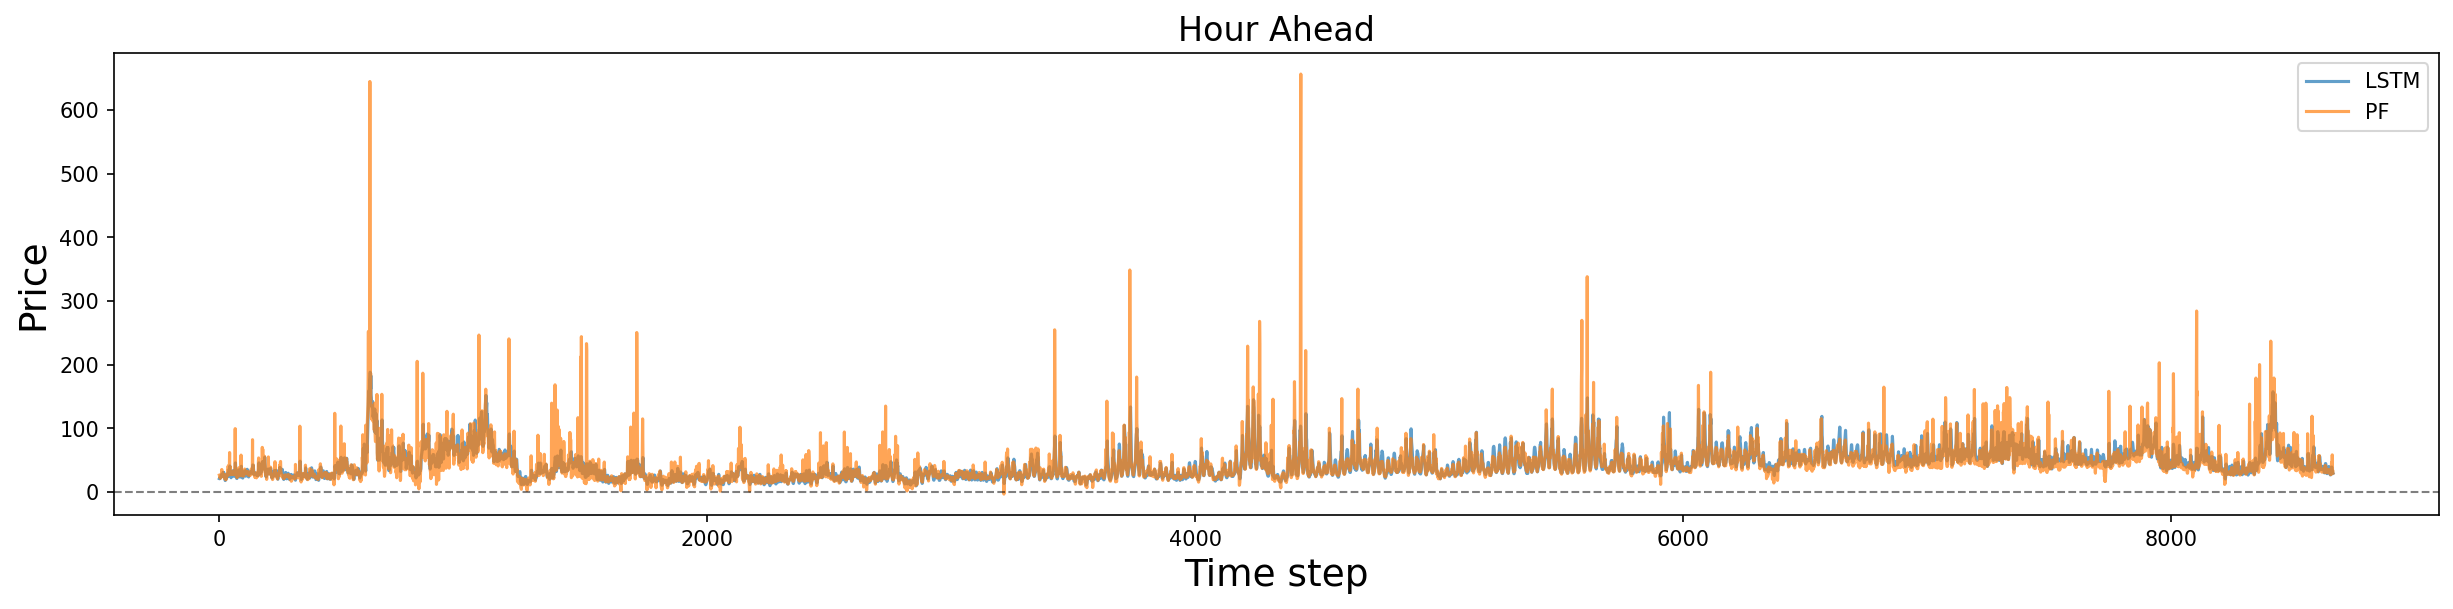

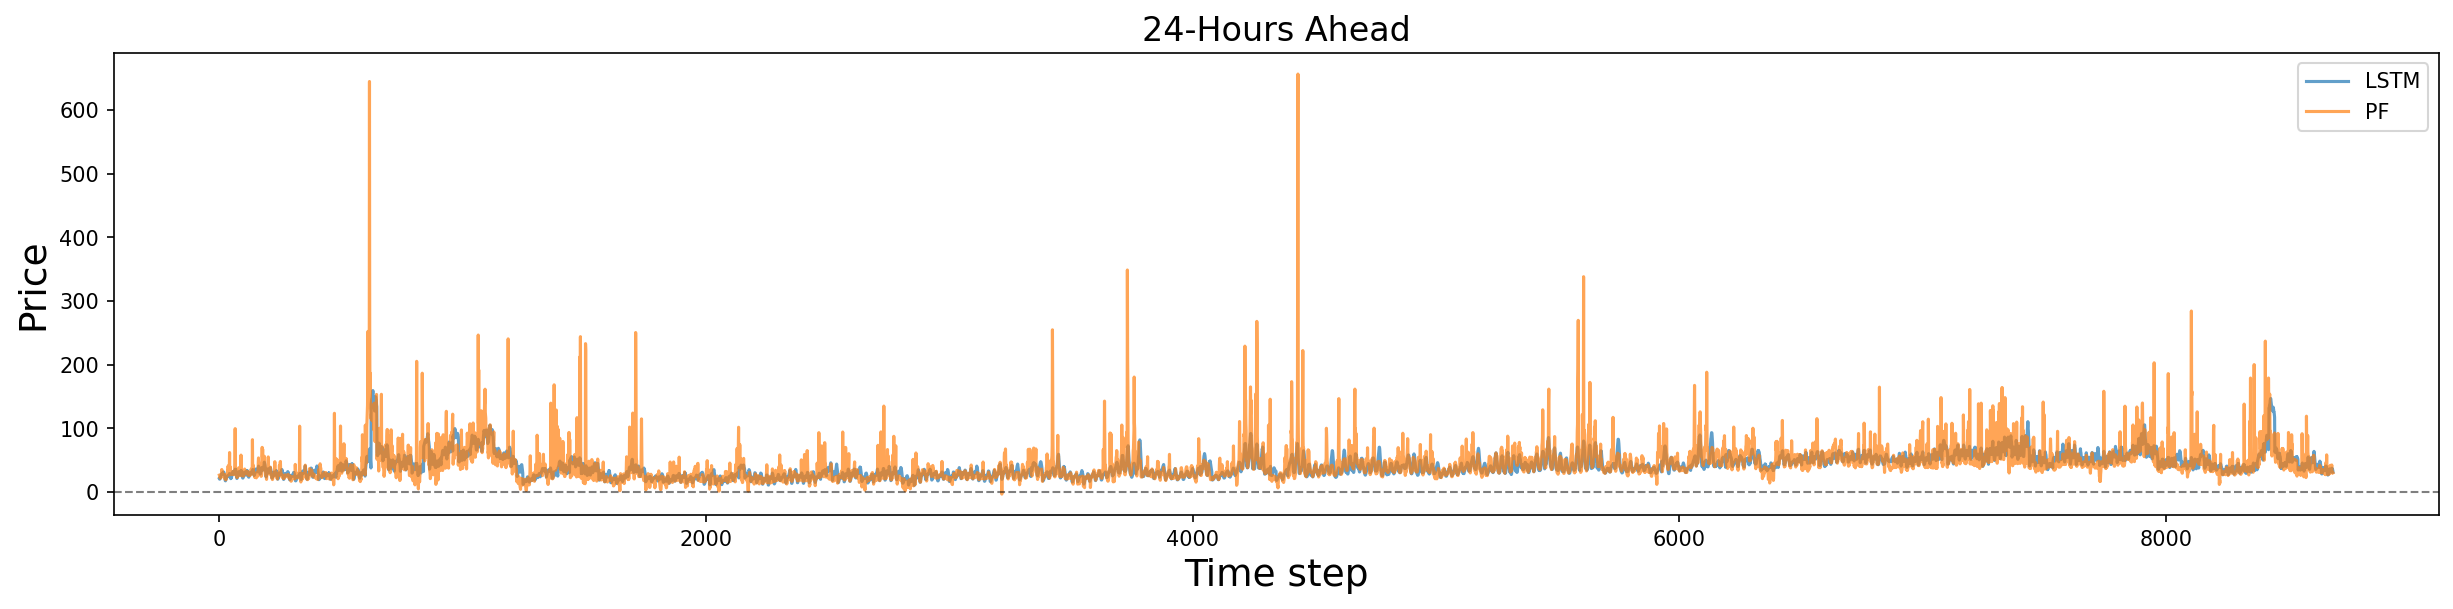

In [38]:
# Evaluation metrics
# 24 hours ahead
errors = y_test_pred_invlog[:,0] - y_test_lstm_invlog[:,0,0]
print('Hour Ahead Evaluation')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

errors = y_test_pred_invlog[::24,:] - y_test_lstm_invlog[::24,:,0]
print('24-Hours Ahead Evaluation')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

plot_predictions(y_test_pred_invlog[:,0].flatten(), y_test_lstm_invlog[:,0,0].flatten(), 'Hour Ahead')
plot_predictions(y_test_pred_invlog[::24,:].flatten(), y_test_lstm_invlog[::24,:,0].flatten(), '24-Hours Ahead')


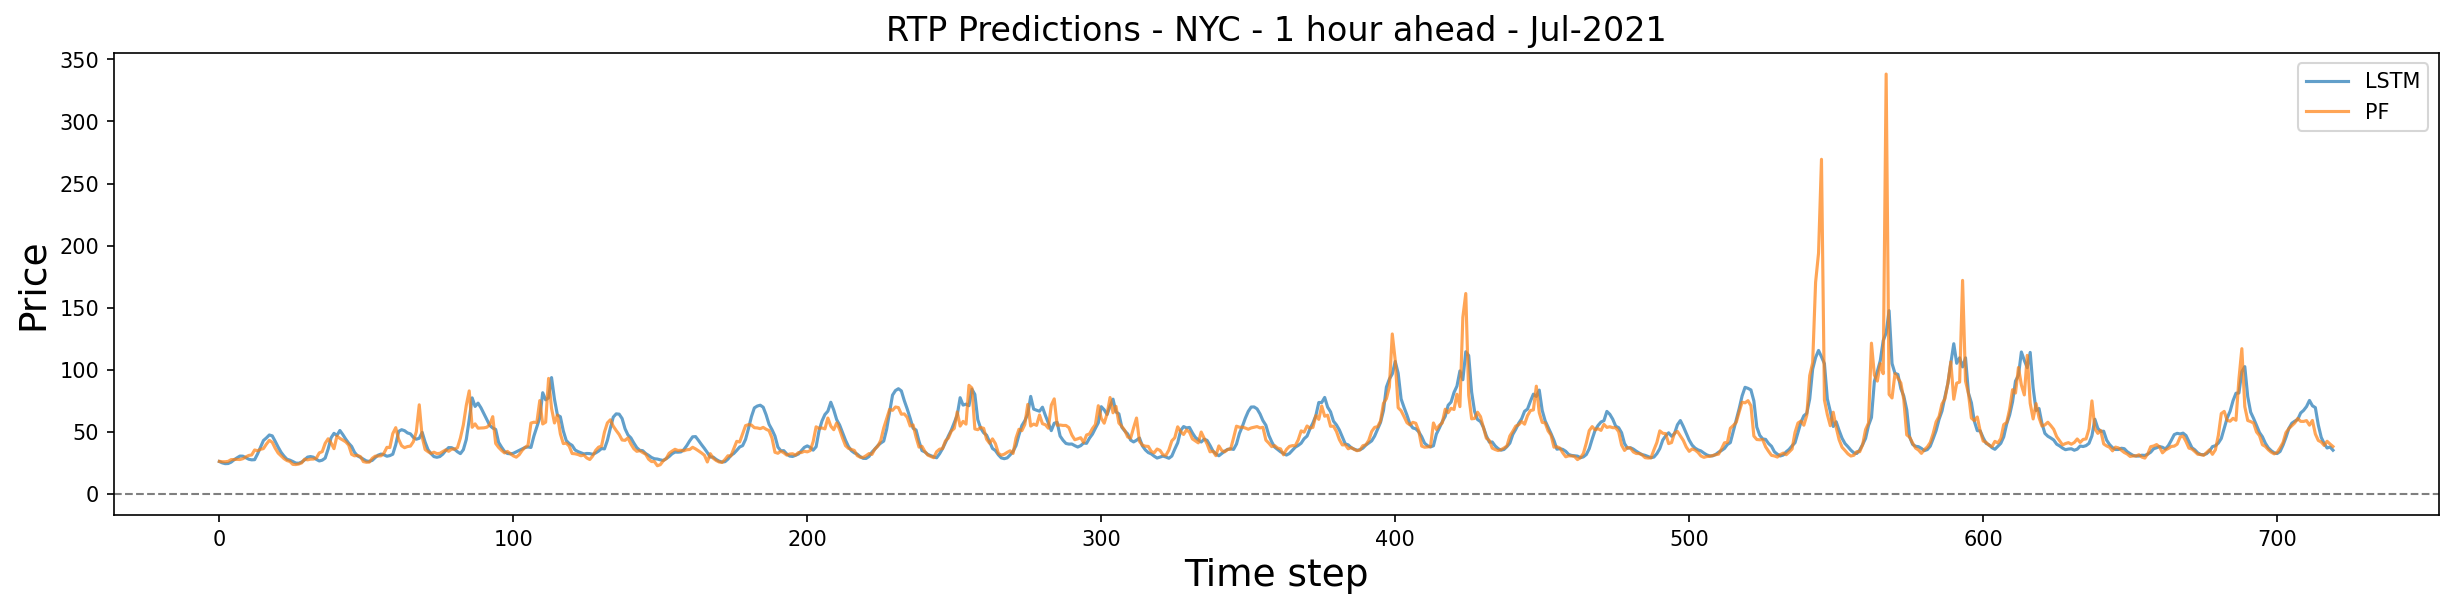

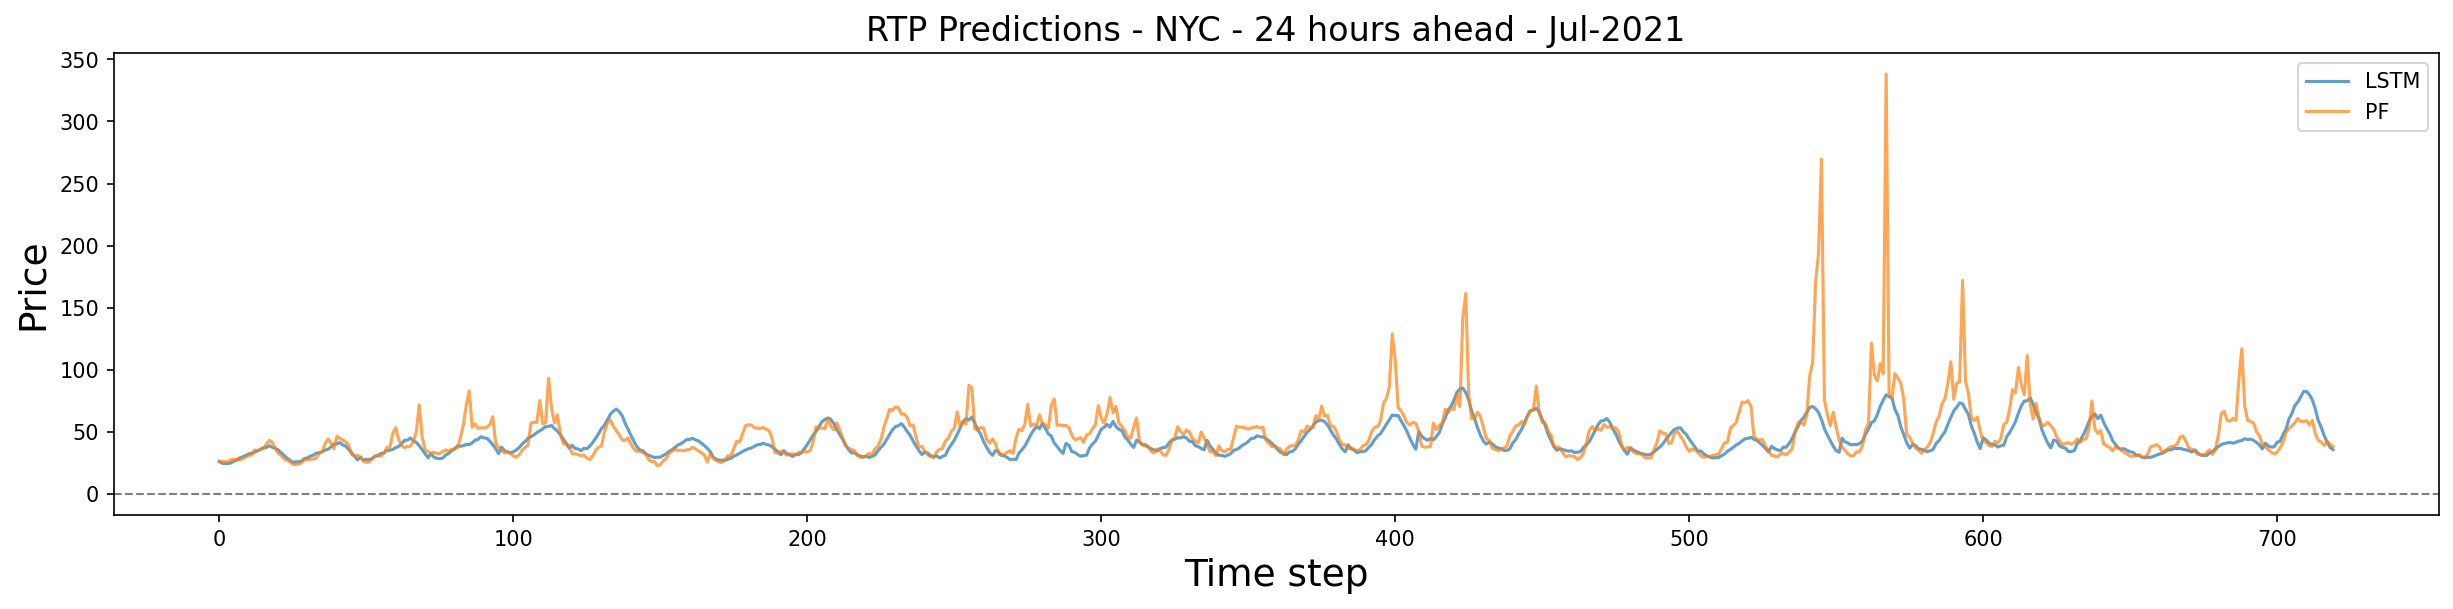

In [39]:
i = 7*24*30
j = i + 24*30

plot_predictions(y_test_pred_invlog[i:j,0].flatten(),
               y_test_lstm_invlog[i:j,0,0].flatten(),
               'RTP Predictions - NYC - 1 hour ahead - Jul-2021')

plot_predictions(y_test_pred_invlog[i:j:24,:].flatten(),
               y_test_lstm_invlog[i:j:24,:].flatten(),
               'RTP Predictions - NYC - 24 hours ahead - Jul-2021')
